# Clean and harmonise SR1.5 scenarios

1. clean the variable names
1. harmonise scenarios using [aneris, see Gidden et al. (2019)](https://doi.org/10.1016/j.envsoft.2018.04.002)
1. write out clean, re-harmonised SR1.5 scenarios

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import datetime as dt
import glob
import os.path

import aneris.convenience
import dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
import pymagicc.io
import scmdata
import tqdm.autonotebook as tqdman
import xarray as xr

import utils

<IPython.core.display.Javascript object>

/data/ubuntu-znicholls/miniconda3/envs/one-earth-2022/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  del sys.path[0]


<IPython.core.display.Javascript object>

In [3]:
dotenv.load_dotenv()

True

<IPython.core.display.Javascript object>

In [4]:
plt.rcParams["figure.figsize"] = (12, 8)

<IPython.core.display.Javascript object>

In [5]:
OUT_FILE = os.path.join(
    utils.DATA_DIR,
    "processed",
    "harmonised-sr15-scenarios",
    "harmonised-sr15-emissions.nc",
)
os.makedirs(os.path.dirname(OUT_FILE), exist_ok=True)
OUT_FILE

'/data2/ubuntu-znicholls/one-earth-2022/notebooks/../data/processed/harmonised-sr15-scenarios/harmonised-sr15-emissions.nc'

<IPython.core.display.Javascript object>

In [6]:
SR15_SCENARIOS_CSV = os.path.join(
    utils.DATA_DIR,
    "raw",
    "sr15-scenarios",
    "sr15_scenarios.csv",
)
SR15_SCENARIOS_CSV

'/data2/ubuntu-znicholls/one-earth-2022/notebooks/../data/raw/sr15-scenarios/sr15_scenarios.csv'

<IPython.core.display.Javascript object>

## Load data

In [7]:
rcmip_emms_file = pooch.retrieve(
    url="https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-emissions-annual-means-v5-1-0.csv",
    known_hash=f"md5:4044106f55ca65b094670e7577eaf9b3",
    path=os.path.join(utils.DATA_DIR, "raw", "rcmip"),
    fname="rcmip-emissions-annual-means-v5-1-0.csv",
)
rcmip_emms = scmdata.ScmRun(
    rcmip_emms_file,
    lowercase_cols=True,
)
rcmip_emms

<ScmRun (timeseries: 9262, timepoints: 751)>
Time:
	Start: 1750-01-01T00:00:00
	End: 2500-01-01T00:00:00
Meta:
	         activity_id mip_era        model region          scenario       unit  \
	0     not_applicable   CMIP5          AIM  World             rcp60   Mt BC/yr   
	1     not_applicable   CMIP5          AIM  World             rcp60  Mt CH4/yr   
	2     not_applicable   CMIP5          AIM  World             rcp60   Mt CO/yr   
	3     not_applicable   CMIP5          AIM  World             rcp60  Mt CO2/yr   
	4     not_applicable   CMIP5          AIM  World             rcp60  Mt CO2/yr   
	...              ...     ...          ...    ...               ...        ...   
	9257  not_applicable   CMIP5  unspecified  World  historical-cmip5  Mt NH3/yr   
	9258  not_applicable   CMIP5  unspecified  World  historical-cmip5  Mt NOx/yr   
	9259  not_applicable   CMIP5  unspecified  World  historical-cmip5   Mt OC/yr   
	9260  not_applicable   CMIP5  unspecified  World  historical-cmip5  

<IPython.core.display.Javascript object>

In [8]:
sr15_data = scmdata.ScmRun(SR15_SCENARIOS_CSV, lowercase_cols=True)
sr15_data

<ScmRun (timeseries: 9453, timepoints: 30)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2105-01-01T00:00:00
Meta:
	     climate_model              model region                scenario todo  \
	0      unspecified            AIM_2_0  World  ADVANCE_2020_1.5C-2100  SET   
	1      unspecified            AIM_2_0  World  ADVANCE_2020_1.5C-2100  SET   
	2      unspecified            AIM_2_0  World  ADVANCE_2020_1.5C-2100  SET   
	3      unspecified            AIM_2_0  World  ADVANCE_2020_1.5C-2100  SET   
	4      unspecified            AIM_2_0  World  ADVANCE_2020_1.5C-2100  SET   
	...            ...                ...    ...                     ...  ...   
	9448   unspecified  WITCH-GLOBIOM_4_4  World       CD-LINKS_NoPolicy  SET   
	9449   unspecified  WITCH-GLOBIOM_4_4  World       CD-LINKS_NoPolicy  SET   
	9450   unspecified  WITCH-GLOBIOM_4_4  World       CD-LINKS_NoPolicy  SET   
	9451   unspecified  WITCH-GLOBIOM_4_4  World       CD-LINKS_NoPolicy  SET   
	9452   unspecified  WITCH-GLOBI

<IPython.core.display.Javascript object>

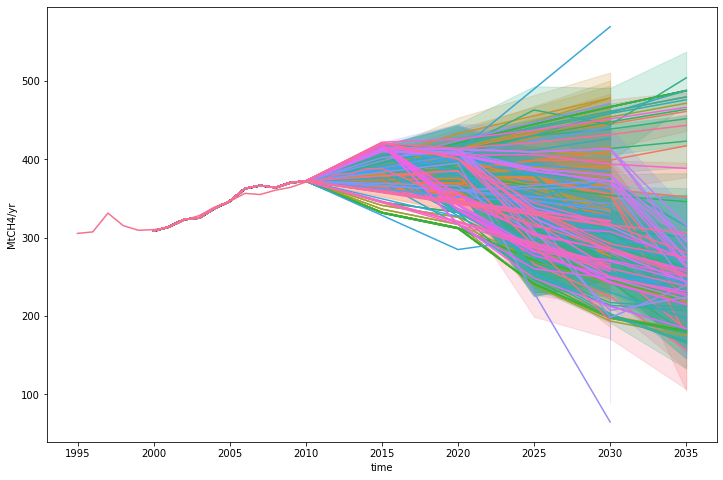

<IPython.core.display.Javascript object>

In [9]:
vfilter = ["*CO2|MAGICC Fossil and Industrial"]  # , "*CO2|MAGICC AFOLU"]
unit = "GtCO2/yr"
vfilter = "*CH4"
unit = "MtCH4/yr"

sr15_data.append(
    rcmip_emms.filter(
        variable=vfilter,
        scenario="ssp126",
        region="World",
    )
).filter(variable=vfilter, year=range(1995, 2035 + 1)).convert_unit(unit).lineplot(
    style="variable",
    legend=False,
)

## Rename variables

In [10]:
historical_data = rcmip_emms.filter(scenario="ssp245", year=range(1750, 2015 + 1))
historical_data["scenario"] = "historical"
historical_data_openscm_runner = utils.rcmip_to_openscm_runner(
    historical_data.filter(region="World")
)

sr15_data_openscm_runner = utils.pymagicc_to_openscm_runner(sr15_data)

<IPython.core.display.Javascript object>

In [11]:
missing_vars = set(sr15_data_openscm_runner.get_unique_meta("variable")) - set(
    historical_data_openscm_runner.get_unique_meta("variable")
)
assert not missing_vars, missing_vars

<IPython.core.display.Javascript object>

In [12]:
scenarios = sr15_data_openscm_runner.interpolate(
    [dt.datetime(y, 1, 1) for y in range(2000, 2101, 5)]
)
scenarios = scenarios.convert_unit(
    "Mt NOx / yr", variable="Emissions|NOx", context="NOx_conversions"
)
scenarios = scenarios.drop_meta(["todo", "climate_model", "unit_context"])
scenarios

<ScmRun (timeseries: 9453, timepoints: 21)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	                  model region                scenario           unit  \
	0               AIM_2_0  World  ADVANCE_2020_1.5C-2100    Mt NOx / yr   
	1               AIM_2_0  World      ADVANCE_2020_Med2C    Mt NOx / yr   
	2               AIM_2_0  World       ADVANCE_2020_WB2C    Mt NOx / yr   
	3               AIM_2_0  World      ADVANCE_2030_Med2C    Mt NOx / yr   
	4               AIM_2_0  World  ADVANCE_2030_Price1.5C    Mt NOx / yr   
	...                 ...    ...                     ...            ...   
	9448  WITCH-GLOBIOM_4_4  World       CD-LINKS_NoPolicy      Mt N / yr   
	9449  WITCH-GLOBIOM_4_4  World       CD-LINKS_NoPolicy  Mt NMVOC / yr   
	9450  WITCH-GLOBIOM_4_4  World       CD-LINKS_NoPolicy     Mt OC / yr   
	9451  WITCH-GLOBIOM_4_4  World       CD-LINKS_NoPolicy    kt SF6 / yr   
	9452  WITCH-GLOBIOM_4_4  World       CD-LINKS_NoPolicy      Mt S / yr   
	


<IPython.core.display.Javascript object>

In [13]:
scenarios.get_unique_meta("variable")

['Emissions|NOx',
 'Emissions|BC',
 'Emissions|C2F6',
 'Emissions|C6F14',
 'Emissions|CF4',
 'Emissions|CH4',
 'Emissions|CO',
 'Emissions|CO2|MAGICC AFOLU',
 'Emissions|CO2|MAGICC Fossil and Industrial',
 'Emissions|HFC125',
 'Emissions|HFC134a',
 'Emissions|HFC143a',
 'Emissions|HFC227ea',
 'Emissions|HFC23',
 'Emissions|HFC245fa',
 'Emissions|HFC32',
 'Emissions|HFC4310mee',
 'Emissions|N2O',
 'Emissions|NH3',
 'Emissions|VOC',
 'Emissions|OC',
 'Emissions|SF6',
 'Emissions|Sulfur']

<IPython.core.display.Javascript object>

In [14]:
overrides = pd.DataFrame(
    [
        {"variable": v, "method": "reduce_ratio_2080"}
        for v in [
            "Emissions|CF4",
            "Emissions|C2F6",
            "Emissions|C6F14",
        ]
    ]
)
overrides

variable             method
0    Emissions|CF4  reduce_ratio_2080
1   Emissions|C2F6  reduce_ratio_2080
2  Emissions|C6F14  reduce_ratio_2080

<IPython.core.display.Javascript object>

In [15]:
historical_data_openscm_runner = historical_data_openscm_runner.convert_unit(
    "Mt N / yr", variable="*NH3", context="NH3_conversions"
).drop_meta("unit_context")

<IPython.core.display.Javascript object>

In [16]:
scen_harmonised = aneris.convenience.harmonise_all(
    scenarios.filter(scenario="*").timeseries(time_axis="year"),
    history=historical_data_openscm_runner.filter(
        variable=sr15_data_openscm_runner.get_unique_meta("variable")
    )
    .drop_meta(["activity_id", "mip_era"])
    .timeseries(time_axis="year"),
    harmonisation_year=2015,
    overrides=overrides,
)
scen_harmonised = scmdata.ScmRun(scen_harmonised).filter(year=range(2015, 3000))
scen_harmonised

<ScmRun (timeseries: 9453, timepoints: 18)>
Time:
	Start: 2015-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	                  model region                scenario           unit  \
	0               AIM_2_0  World  ADVANCE_2020_1.5C-2100    Mt NOx / yr   
	1               AIM_2_0  World      ADVANCE_2020_Med2C    Mt NOx / yr   
	2               AIM_2_0  World       ADVANCE_2020_WB2C    Mt NOx / yr   
	3               AIM_2_0  World      ADVANCE_2030_Med2C    Mt NOx / yr   
	4               AIM_2_0  World  ADVANCE_2030_Price1.5C    Mt NOx / yr   
	...                 ...    ...                     ...            ...   
	9448  WITCH-GLOBIOM_4_4  World       CD-LINKS_NoPolicy      Mt N / yr   
	9449  WITCH-GLOBIOM_4_4  World       CD-LINKS_NoPolicy  Mt NMVOC / yr   
	9450  WITCH-GLOBIOM_4_4  World       CD-LINKS_NoPolicy     Mt OC / yr   
	9451  WITCH-GLOBIOM_4_4  World       CD-LINKS_NoPolicy    kt SF6 / yr   
	9452  WITCH-GLOBIOM_4_4  World       CD-LINKS_NoPolicy      Mt S / yr   
	


<IPython.core.display.Javascript object>

In [17]:
sorted(scen_harmonised.get_unique_meta("variable"))

['Emissions|BC',
 'Emissions|C2F6',
 'Emissions|C6F14',
 'Emissions|CF4',
 'Emissions|CH4',
 'Emissions|CO',
 'Emissions|CO2|MAGICC AFOLU',
 'Emissions|CO2|MAGICC Fossil and Industrial',
 'Emissions|HFC125',
 'Emissions|HFC134a',
 'Emissions|HFC143a',
 'Emissions|HFC227ea',
 'Emissions|HFC23',
 'Emissions|HFC245fa',
 'Emissions|HFC32',
 'Emissions|HFC4310mee',
 'Emissions|N2O',
 'Emissions|NH3',
 'Emissions|NOx',
 'Emissions|OC',
 'Emissions|SF6',
 'Emissions|Sulfur',
 'Emissions|VOC']

<IPython.core.display.Javascript object>

  0%|          | 0/13 [00:00<?, ?it/s]

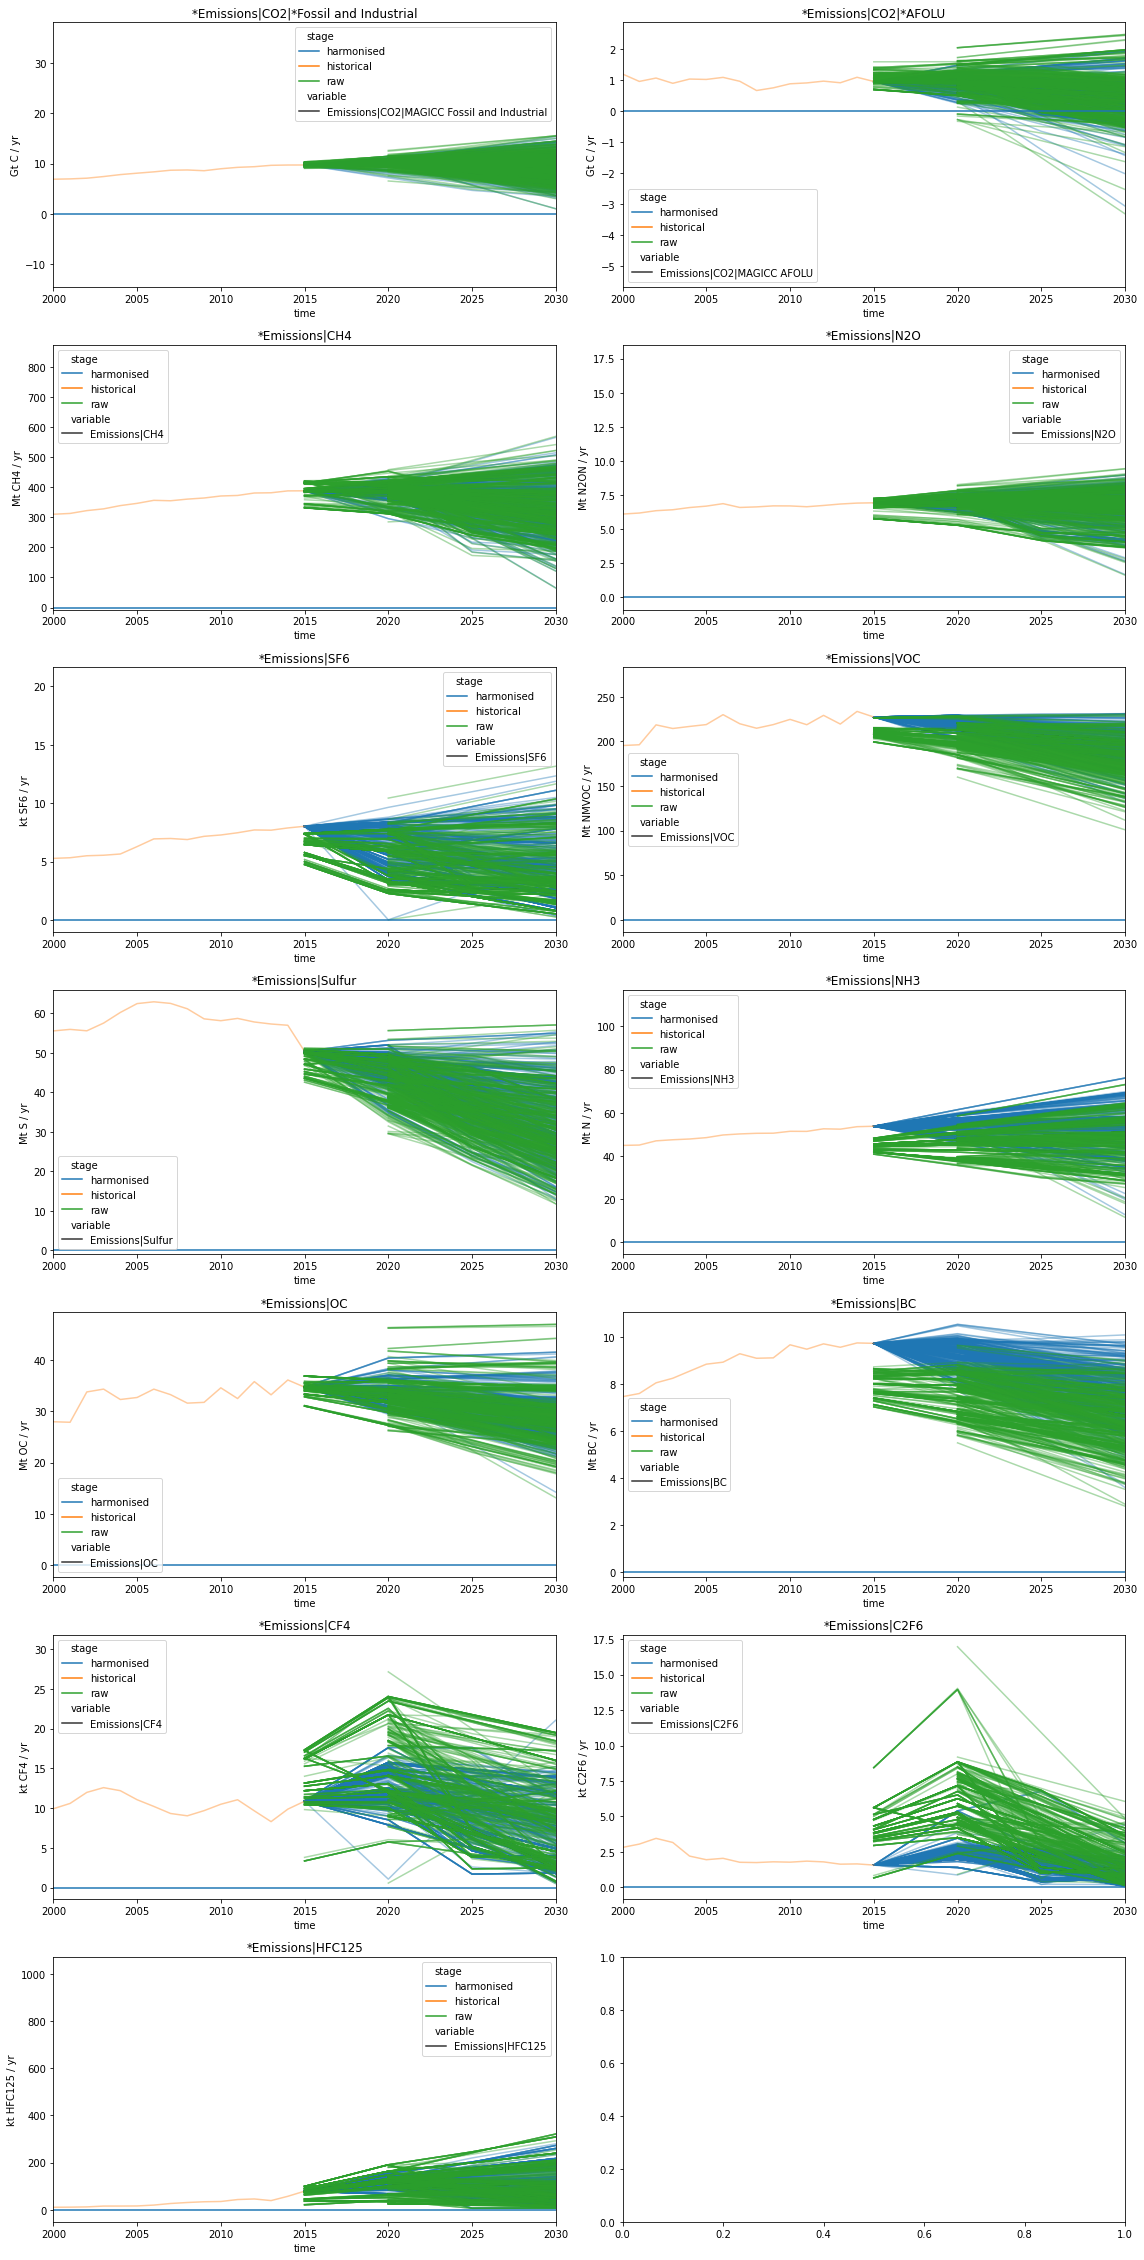

<IPython.core.display.Javascript object>

In [18]:
nrows = 7
fig, axes = plt.subplots(figsize=(16, 4.5 * nrows), nrows=nrows, ncols=2)

variable_ax = (
    ("*Emissions|CO2|*Fossil and Industrial", axes[0][0]),
    ("*Emissions|CO2|*AFOLU", axes[0][1]),
    ("*Emissions|CH4", axes[1][0]),
    ("*Emissions|N2O", axes[1][1]),
    ("*Emissions|SF6", axes[2][0]),
    ("*Emissions|VOC", axes[2][1]),
    ("*Emissions|Sulfur", axes[3][0]),
    ("*Emissions|NH3", axes[3][1]),
    ("*Emissions|OC", axes[4][0]),
    ("*Emissions|BC", axes[4][1]),
    ("*Emissions|CF4", axes[5][0]),
    ("*Emissions|C2F6", axes[5][1]),
    ("*Emissions|HFC125", axes[6][0]),
)
for i, (variable, ax) in enumerate(tqdman.tqdm(variable_ax)):
    scen_harmonised_var = scen_harmonised.filter(variable=variable)
    scen_harmonised_var_unit = scen_harmonised_var.get_unique_meta(
        "unit", no_duplicates=True
    )
    scen_harmonised_var["stage"] = "harmonised"

    historical_data_openscm_runner_var = (
        historical_data_openscm_runner.filter(variable=variable)
        .convert_unit(scen_harmonised_var_unit)
        .filter(year=range(2000, 2016))
    )
    historical_data_openscm_runner_var["stage"] = "historical"

    sr15_openscm_runner_var = sr15_data_openscm_runner.filter(
        variable=variable,
        scenario=scen_harmonised.get_unique_meta("scenario"),
        year=range(2015, 2100 + 1),
    ).convert_unit(scen_harmonised_var_unit)
    sr15_openscm_runner_var["stage"] = "raw"

    pdf = scmdata.run_append(
        [
            scen_harmonised_var,
            historical_data_openscm_runner_var,
            sr15_openscm_runner_var,
        ]
    )
    pdf["model_scenario"] = pdf["model"] + pdf["scenario"]

    pdf.filter(year=range(2000, 2101)).lineplot(
        hue="stage",
        style="variable",
        units="model_scenario",
        estimator=None,
        ci=None,
        ax=ax,
        legend="brief",
        #         linewidth=0.25,
        alpha=0.4,
        time_axis="year",
        # palette=SCENARIO_PALETTE,
    )
    ax.set_title(variable)
    ax.set_xlim([2000, 2030])
    ax.axhline(0)
#     break

plt.tight_layout()

In [19]:
scen_harmonised_var.head()

time                                                                              2015-01-01  \
model   region scenario               stage      unit           variable                       
AIM_2_0 World  ADVANCE_2020_1.5C-2100 harmonised kt HFC125 / yr Emissions|HFC125     78.7906   
               ADVANCE_2020_Med2C     harmonised kt HFC125 / yr Emissions|HFC125     78.7906   
               ADVANCE_2020_WB2C      harmonised kt HFC125 / yr Emissions|HFC125     78.7906   
               ADVANCE_2030_Med2C     harmonised kt HFC125 / yr Emissions|HFC125     78.7906   
               ADVANCE_2030_Price1.5C harmonised kt HFC125 / yr Emissions|HFC125     78.7906   

time                                                                              2020-01-01  \
model   region scenario               stage      unit           variable                       
AIM_2_0 World  ADVANCE_2020_1.5C-2100 harmonised kt HFC125 / yr Emissions|HFC125  130.290821   
               ADVANCE_2020_Med2C     harmonised kt HFC125 / yr Emissions|HFC125  124.449869   
               ADVANCE_2020_WB2C      harmonised kt HFC125 / yr Emissions|HFC125  130.290673   
               ADVANCE_2030_Med2C     harmonised kt HFC125 / yr Emissions|HFC125  138.417353   
               ADVANCE_2030_Price1.5C harmonised kt HFC125 / yr Emissions|HFC125  138.413833   

time                                                                              2025-01-01  \
model   region scenario               stage      unit           variable                       
AIM_2_0 World  ADVANCE_2020_1.5C-2100 harmonised kt HFC125 / yr Emissions|HFC125   89.184840   
               ADVANCE_2020_Med2C     harmonised kt HFC125 / yr Emissions|HFC125  124.444713   
               ADVANCE_2020_WB2C      harmonised kt HFC125 / yr Emissions|HFC125   89.340230   
               ADVANCE_2030_Med2C     harmonised kt HFC125 / yr Emissions|HFC125  166.738472   
               ADVANCE_2030_Price1.5C harmonised kt HFC125 / yr Emissions|HFC125  166.596627   

time                                                                              2030-01-01  \
model   region scenario               stage      unit           variable                       
AIM_2_0 World  ADVANCE_2020_1.5C-2100 harmonised kt HFC125 / yr Emissions|HFC125   34.818079   
               ADVANCE_2020_Med2C     harmonised kt HFC125 / yr Emissions|HFC125  121.313858   
               ADVANCE_2020_WB2C      harmonised kt HFC125 / yr Emissions|HFC125   34.956231   
               ADVANCE_2030_Med2C     harmonised kt HFC125 / yr Emissions|HFC125  198.695236   
               ADVANCE_2030_Price1.5C harmonised kt HFC125 / yr Emissions|HFC125  198.578310   

time                                                                              2035-01-01  \
model   region scenario               stage      unit           variable                       
AIM_2_0 World  ADVANCE_2020_1.5C-2100 harmonised kt HFC125 / yr Emissions|HFC125   28.116858   
               ADVANCE_2020_Med2C     harmonised kt HFC125 / yr Emissions|HFC125  100.029859   
               ADVANCE_2020_WB2C      harmonised kt HFC125 / yr Emissions|HFC125   28.215688   
               ADVANCE_2030_Med2C     harmonised kt HFC125 / yr Emissions|HFC125  222.251684   
               ADVANCE_2030_Price1.5C harmonised kt HFC125 / yr Emissions|HFC125  218.942958   

time                                                                              2040-01-01  \
model   region scenario               stage      unit           variable                       
AIM_2_0 World  ADVANCE_2020_1.5C-2100 harmonised kt HFC125 / yr Emissions|HFC125   20.777342   
               ADVANCE_2020_Med2C     harmonised kt HFC125 / yr Emissions|HFC125   76.456163   
               ADVANCE_2020_WB2C      harmonised kt HFC125 / yr Emissions|HFC125   20.936953   
               ADVANCE_2030_Med2C     harmonised kt HFC125 / yr Emissions|HFC125  246.754856   
               ADVANCE_2030_Price1.5C harmonised kt HFC125 

<IPython.core.display.Javascript object>

In [20]:
historical_data_openscm_runner_var.head()

time                                                                                                 2000-01-01  \
activity_id    mip_era model           region scenario   stage      unit           variable                       
not_applicable CMIP6   MESSAGE-GLOBIOM World  historical historical kt HFC125 / yr Emissions|HFC125   10.640667   

time                                                                                                 2001-01-01  \
activity_id    mip_era model           region scenario   stage      unit           variable                       
not_applicable CMIP6   MESSAGE-GLOBIOM World  historical historical kt HFC125 / yr Emissions|HFC125   11.075295   

time                                                                                                 2002-01-01  \
activity_id    mip_era model           region scenario   stage      unit           variable                       
not_applicable CMIP6   MESSAGE-GLOBIOM World  historical historical kt HFC125 / yr Emissions|HFC125   12.214474   

time                                                                                                 2003-01-01  \
activity_id    mip_era model           region scenario   stage      unit           variable                       
not_applicable CMIP6   MESSAGE-GLOBIOM World  historical historical kt HFC125 / yr Emissions|HFC125   15.640539   

time                                                                                                 2004-01-01  \
activity_id    mip_era model           region scenario   stage      unit           variable                       
not_applicable CMIP6   MESSAGE-GLOBIOM World  historical historical kt HFC125 / yr Emissions|HFC125   15.758879   

time                                                                                                 2005-01-01  \
activity_id    mip_era model           region scenario   stage      unit           variable                       
not_applicable CMIP6   MESSAGE-GLOBIOM World  historical historical kt HFC125 / yr Emissions|HFC125   16.143675   

time                                                                                                 2006-01-01  \
activity_id    mip_era model           region scenario   stage      unit           variable                       
not_applicable CMIP6   MESSAGE-GLOBIOM World  historical historical kt HFC125 / yr Emissions|HFC125   19.891066   

time                                                                                                 2007-01-01  \
activity_id    mip_era model           region scenario   stage      unit           variable                       
not_applicable CMIP6   MESSAGE-GLOBIOM World  historical historical kt HFC125 / yr Emissions|HFC125   26.595246   

time                                                                                                 2008-01-01  \
activity_id    mip_era model           region scenario   stage      unit           variable                       
not_applicable CMIP6   MESSAGE-GLOBIOM World  historical historical kt HFC125 / yr Emissions|HFC125   30.815622   

time                                                                                                 2009-01-01  \
activity_id    mip_era model           region scenario   stage      unit           variable                       
not_applicable CMIP6   MESSAGE-GLOBIOM World  historical historical kt HFC125 / yr Emissions|HFC125   33.926872   

time                                                                                                 2010-01-01  \
activity_id    mip_era model           region scenario   stage      unit           variable                       
not_applicable CMIP6   MESSAGE-GLOBIOM World  historical historical kt HFC125 / yr Emissions|HFC125   35.069515   

time                                                                                                 2011-01-01  \
activity_id    mip_era model           region scenario   stage      unit       

<IPython.core.display.Javascript object>

In [21]:
scen_harmonised.to_nc(OUT_FILE, dimensions=("scenario",), extras=("model",))
OUT_FILE

'/data2/ubuntu-znicholls/one-earth-2022/notebooks/../data/processed/harmonised-sr15-scenarios/harmonised-sr15-emissions.nc'

<IPython.core.display.Javascript object>

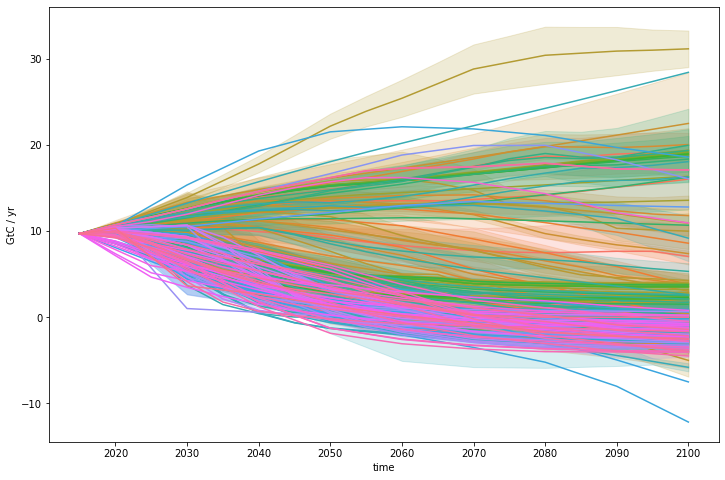

<IPython.core.display.Javascript object>

In [22]:
scen_harmonised.filter(variable="Emissions|CO2|*Fossil*").convert_unit(
    "GtC / yr"
).lineplot(legend=False)

In [23]:
xr.load_dataset(OUT_FILE)

<xarray.Dataset>
Dimensions:                                       (time: 18, scenario: 172, _id: 21)
Coordinates:
  * time                                          (time) datetime64[ns] 2015-...
  * scenario                                      (scenario) object 'ADVANCE_...
  * _id                                           (_id) int64 0 1 2 ... 18 19 20
    model                                         (_id) object 'AIM_2_0' ... ...
Data variables: (12/23)
    Emissions__BC                                 (scenario, time, _id) float64 ...
    Emissions__C2F6                               (scenario, time, _id) float64 ...
    Emissions__C6F14                              (scenario, time, _id) float64 ...
    Emissions__CF4                                (scenario, time, _id) float64 ...
    Emissions__CH4                                (scenario, time, _id) float64 ...
    Emissions__CO                                 (scenario, time, _id) float64 ...
    ...                                            ...
    Emissions__NH3                                (scenario, time, _id) float64 ...
    Emissions__NOx                                (scenario, time, _id) float64 ...
    Emissions__OC                                 (scenario, time, _id) float64 ...
    Emissions__SF6                                (scenario, time, _id) float64 ...
    Emissions__Sulfur                             (scenario, time, _id) float64 ...
    Emissions__VOC                                (scenario, time, _id) float64 ...
Attributes:
    scmdata_metadata_region:  World
    created_at:               2022-06-01T13:55:13.622421
    _scmdata_version:         0.14.1

<IPython.core.display.Javascript object>